In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from sklearn.metrics import mean_absolute_error, mean_squared_error


In [29]:
df_penta_train = pd.read_excel(r'C:\Users\Kun\Downloads\train2.xlsx')
df_penta_train.head(10)

,Spd_Engine,Trq_Engine,Flw_Fuel
0,1901,2044,23.4
1,1945,1682,23.4
2,1954,1370,21.9
3,1958,1335,17.0
4,1975,1151,16.1
5,1989,964,15.2
6,1999,858,13.6
7,2000,791,12.1
8,2003,749,11.1
9,2003,732,10.5


In [30]:
df_penta_train = df_penta_train.loc[df_penta_train.Trq_Engine > 0]

In [31]:
df_penta_train.describe()

,Spd_Engine,Trq_Engine,Flw_Fuel
count,16738.000000,16738.000000,16738.000000
mean,1341.837734,1168.131975,9.577590
std,371.154802,727.777496,6.133201
min,554.000000,1.000000,0.300000
25%,1099.000000,599.000000,4.200000
50%,1312.000000,1004.000000,8.400000
75%,1606.750000,1799.000000,14.300000
max,2021.000000,2648.000000,23.600000


[Text(0.5, 0, 'Engine Torque'),
 Text(0, 0.5, 'Flw_FuelDiesel'),
 Text(0.5, 1.0, 'Engine Torque VS Flw_FuelDiesel')]

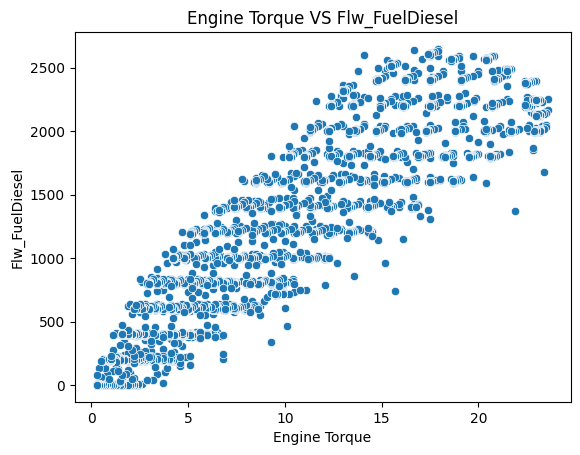

In [32]:
sns.scatterplot(data=df_penta_train, x=df_penta_train.Flw_Fuel, y=df_penta_train.Trq_Engine).set(xlabel="Engine Torque", ylabel = "Flw_FuelDiesel", title= "Engine Torque VS Flw_FuelDiesel")

[Text(0.5, 0, 'Engine Speed'),
 Text(0, 0.5, 'Flw_FuelDiesel'),
 Text(0.5, 1.0, 'Engine Speed VS Flw_FuelDiesel')]

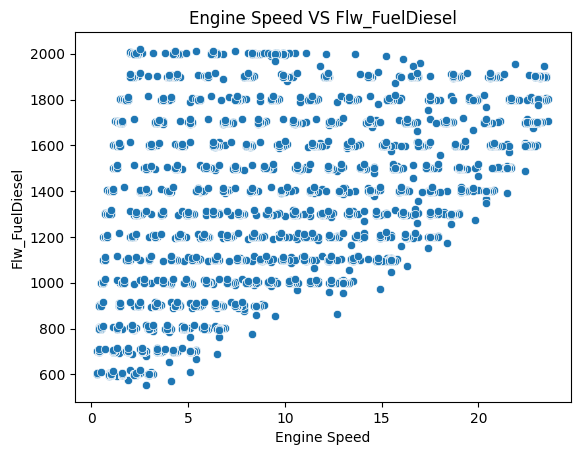

In [33]:
sns.scatterplot(data=df_penta_train, x=df_penta_train.Flw_Fuel, y=df_penta_train.Spd_Engine).set(xlabel="Engine Speed", ylabel = "Flw_FuelDiesel", title= "Engine Speed VS Flw_FuelDiesel")

In [34]:
X, y = df_penta_train[["Spd_Engine", "Trq_Engine"]], df_penta_train[["Flw_Fuel"]]
X.shape, y.shape

((16738, 2), (16738, 1))

### Features and Target split and scaling

In [35]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)
    
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((11214, 2), (11214, 1), (2762, 2), (2762, 1), (2762, 2), (2762, 1))

In [36]:
scaler = MinMaxScaler()
scaler.fit(X_train)

scaled_X_train = scaler.transform(X_train)
scaled_X_val = scaler.transform(X_val)
scaled_X_test = scaler.transform(X_test)

print(f"{scaled_X_train.min():.2f} ≤ scaled_X_train ≤ {scaled_X_train.max():.2f}")
print(f"{scaled_X_val.min():.2f} ≤ scaled_X_train ≤ {scaled_X_val.max():.2f}")
print(f"{scaled_X_test.min():.2f} ≤ scaled_X_test ≤ {scaled_X_test.max():.2f}") 

0.00 ≤ scaled_X_train ≤ 1.00
0.00 ≤ scaled_X_train ≤ 1.00
0.00 ≤ scaled_X_test ≤ 1.00


In [37]:
scaler_y = MinMaxScaler()
scaler_y.fit_transform(y_train)

scaled_y_train = scaler_y.transform(y_train)
scaled_y_val = scaler_y.transform(y_val)
scaled_y_test = scaler_y.transform(y_test)

print(f"{scaled_y_train.min():.2f} ≤ scaled_y_train ≤ {scaled_y_train.max():.2f}")

0.00 ≤ scaled_y_train ≤ 1.00


# Models

## Linear regression algorithm

In [38]:
from code import interact
from sklearn.linear_model import LinearRegression

model_SVD = LinearRegression(fit_intercept = True)
model_SVD.fit(scaled_X_train, scaled_y_train)
print(f"Parameters: {model_SVD.coef_}")
print(f"Intercept: {model_SVD.intercept_}")

model_SVD.score(scaled_X_val, scaled_y_val)

Parameters: [[0.39119637 0.82881117]]
Intercept: [-0.17874601]


0.948592643306386

In [39]:
import pickle
with open('saved_models/SVD.pickle','wb') as f:
    pickle.dump(model_SVD,f)

## Polynomial regression

- By thinking of the interaction effects between EngineSpeed and SpeedOverGround, I try to use polynomial regression with higher degrees.

### Compare with RMSE with different degrees

In [40]:
from sklearn.preprocessing import PolynomialFeatures

In [49]:
MAE_val = []

for degree in range(1,10):
    model_poly = PolynomialFeatures(degree, include_bias=False)

    train_features = model_poly.fit_transform(scaled_X_train) # find out the polynomial combinations on training data
    val_features = model_poly.transform(scaled_X_val) # find out the polynomial combinations on validation data
    model_lin_reg = LinearRegression() # regression model fit 

    model_lin_reg.fit(train_features, scaled_y_train) 

    y_pred_val = model_lin_reg.predict(val_features) # use the model from train data to predict Y on validation data
    
    MAE_val.append(mean_absolute_error(scaled_y_val, y_pred_val))

[Text(0.5, 0, 'Degree'),
 Text(0, 0.5, 'MAE'),
 Text(0.5, 1.0, 'MAE on validation data for different degrees of polynomial')]

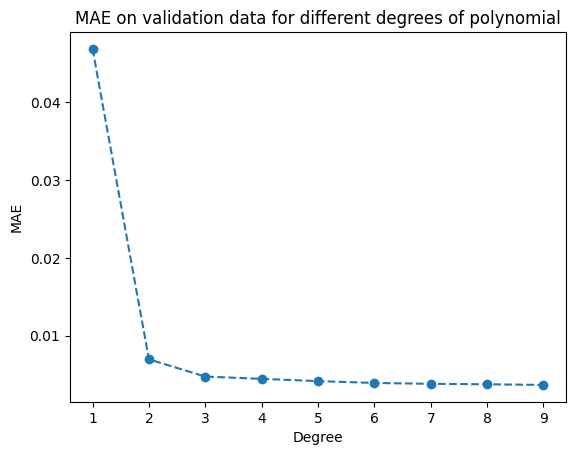

In [50]:
fig, ax = plt.figure(), plt.axes()

ax.plot(range(1,10), MAE_val[:10],'--o', label = "Validation")
ax.set(xlabel = "Degree", ylabel = "MAE", title = "MAE on validation data for different degrees of polynomial")

In [51]:
poly_model_3 = PolynomialFeatures(3, include_bias=False)
X_train_features = poly_model_3.fit_transform(scaled_X_train)
print(X_train_features.shape)

model_poly = LinearRegression()
model_poly.fit(X_train_features, scaled_y_train)

(11214, 9)


LinearRegression()

In [52]:
X_features_val_3_degree = poly_model_3.fit_transform(scaled_X_val)

model_poly.score(X_features_val_3_degree,scaled_y_val)

0.9980390385564918

In [45]:
with open('saved_models/poly.pickle','wb') as f:
    pickle.dump(model_poly,f)

## KNN regression model

- evaluate the KNN model with different k

In [46]:
from sklearn import neighbors

In [53]:
mae_val = []
for K in range(15):
    K = K+1
    model_knn = neighbors.KNeighborsRegressor(n_neighbors = K)

    model_knn.fit(scaled_X_train, scaled_y_train)  # fit the model
    pred=model_knn.predict(scaled_X_test) # make prediction on test set
    error = mean_absolute_error(scaled_y_test,pred) # calculate mae
    mae_val.append(error) # store mae values
    print('MAE value for k= ' , K , 'is:', error , 'Score(correlation) is:', model_knn.score(scaled_X_test, scaled_y_test))

MAE value for k=  1 is: 0.003003670289303328 Score(correlation) is: 0.9974085779398185
MAE value for k=  2 is: 0.0029205371488596 Score(correlation) is: 0.9975511413063991
MAE value for k=  3 is: 0.00294514041472301 Score(correlation) is: 0.9975420747589063
MAE value for k=  4 is: 0.0029477302321823146 Score(correlation) is: 0.9975657082438727
MAE value for k=  5 is: 0.002929705102665544 Score(correlation) is: 0.9975818209621492
MAE value for k=  6 is: 0.0029156164956869223 Score(correlation) is: 0.9975971000610104
MAE value for k=  7 is: 0.0029046652675732937 Score(correlation) is: 0.9976082823237036
MAE value for k=  8 is: 0.002922285275644631 Score(correlation) is: 0.9976051608678134
MAE value for k=  9 is: 0.0029264937290160065 Score(correlation) is: 0.9976112041738407
MAE value for k=  10 is: 0.0029152539212426234 Score(correlation) is: 0.997609499588004
MAE value for k=  11 is: 0.002909871809686289 Score(correlation) is: 0.9976182622441241
MAE value for k=  12 is: 0.0029113432968

[Text(0.5, 0, 'K-value'),
 Text(0, 0.5, 'MAE'),
 Text(0.5, 1.0, 'MAE on validation data for different k')]

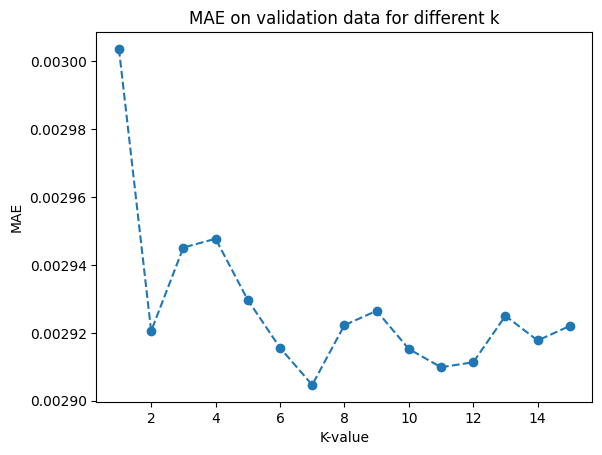

In [55]:
fig, ax = plt.figure(), plt.axes()
ax.plot(range(1,16), mae_val[:15],'--o', label = "Validation")
ax.set(xlabel = "K-value", ylabel = "MAE", title = "MAE on validation data for different k")

In [59]:
from sklearn import neighbors

knn_reg = neighbors.KNeighborsRegressor(n_neighbors=7, weights='uniform') # the defalt value of k is 5
knn_reg.fit(scaled_X_train, scaled_y_train)
knn_reg.score(scaled_X_val, scaled_y_val)

0.9983528176844622

In [61]:
with open('saved_models/knn.pickle','wb') as f:
    pickle.dump(knn_reg,f)

## Decision Tree Regression

In [62]:
from sklearn.tree import DecisionTreeRegressor

In [63]:
mae_val_tree = []

for d in range(20):
    d = d+1
    
    model_tree_regression = DecisionTreeRegressor(max_depth = d) 
    model_tree_regression.fit(X_train, y_train)  # fit the model
    pred = model_tree_regression.predict(X_test) # make prediction on test set
    error = mean_absolute_error(y_test,pred) # calculate mae
    mae_val_tree.append(error) # store mae values
    print('MAE value for max_depth= ' , d , 'is:', error , 'Score is:', model_tree_regression.score(X_test, y_test))

MAE value for max_depth=  1 is: 2.9322755427069453 Score is: 0.6563881806084682
MAE value for max_depth=  2 is: 2.2691097075028273 Score is: 0.7960184916825894
MAE value for max_depth=  3 is: 1.5131202893121538 Score is: 0.9061801947085959
MAE value for max_depth=  4 is: 1.0971269570448907 Score is: 0.9503221368633858
MAE value for max_depth=  5 is: 0.7264930370089888 Score is: 0.9758217076571316
MAE value for max_depth=  6 is: 0.49724137177197575 Score is: 0.9871764480974555
MAE value for max_depth=  7 is: 0.25774509970328174 Score is: 0.9938963300233697
MAE value for max_depth=  8 is: 0.11931919915808535 Score is: 0.9965417036442449
MAE value for max_depth=  9 is: 0.08090367111482882 Score is: 0.9970283240461911
MAE value for max_depth=  10 is: 0.07781692764653074 Score is: 0.9970334442044521
MAE value for max_depth=  11 is: 0.07462557218144034 Score is: 0.997150819821751
MAE value for max_depth=  12 is: 0.07368993790760436 Score is: 0.9971262560319041
MAE value for max_depth=  13 is

<AxesSubplot: title={'center': 'MAE vs max_depth'}>

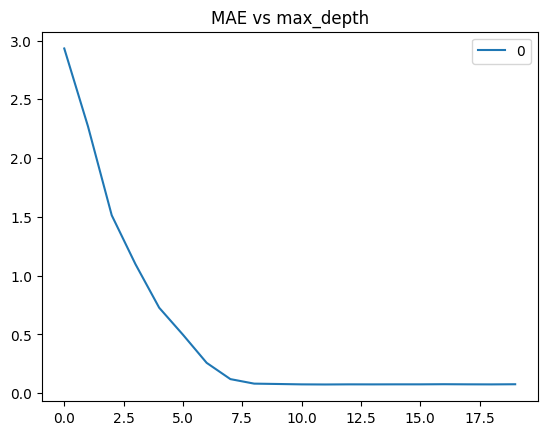

In [64]:
curve = pd.DataFrame(mae_val_tree) 
curve.plot(title = "MAE vs max_depth")

In [65]:
model_tree_regression = DecisionTreeRegressor(max_depth = 7) 

In [67]:
model_tree_regression.fit(scaled_X_train, scaled_y_train) 
# Decision trees methods do not require feature scaling to be performed as they are not sensitive to the the variance in the data.

model_tree_regression.feature_importances_
# return how importent the feature is!

array([0.16659971, 0.83340029])

In [68]:
model_tree_regression.score(scaled_X_val, scaled_y_val)

0.9955496740031401

In [69]:
with open('saved_models/tree_regression.pickle','wb') as f:
    pickle.dump(model_tree_regression,f)

## Gradient Boosting Regressor (Gradient Boosting Decision Tree, GBDT)
- The reason to select this model because of its good performance for time series data based on literatures

reference : https://arxiv.org/abs/2101.02118

In [70]:
from sklearn.ensemble import GradientBoostingRegressor as GBR

In [71]:
gbr = GBR(max_depth = 7) 
gbr.fit(scaled_X_train, scaled_y_train)
gbr.score(scaled_X_val, scaled_y_val)

c:\Users\Kun\.virtualenvs\Deep_learning-JeCDGH9C\lib\site-packages\sklearn\ensemble\_gb.py:570: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.9987138546389724

In [72]:
with open('saved_models/gbr.pickle','wb') as f:
    pickle.dump(gbr,f)

### XGboost model

In [73]:
import xgboost as xgb

In [74]:
xgbr = xgb.XGBRegressor(max_depth=7, booster='gbtree') 

In [77]:
xgbr.fit(scaled_X_train, scaled_y_train)
xgbr.score(scaled_X_val, scaled_y_val)

0.9988441621739935

In [78]:
with open('saved_models/xgbr.pickle','wb') as f:
    pickle.dump(xgbr,f)

## Random forest

In [79]:
from sklearn.ensemble import RandomForestRegressor
rfr = RandomForestRegressor()

In [80]:
rfr.fit(scaled_X_train, scaled_y_train)

score = rfr.score(scaled_X_val, scaled_y_val)
print("R-squared:", score) 

C:\Users\Kun\AppData\Local\Temp\ipykernel_2724\189915855.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfr.fit(scaled_X_train, scaled_y_train)


R-squared: 0.998338201220338


In [81]:
with open('saved_models/rfr.pickle','wb') as f:
    pickle.dump(rfr,f)